In [1]:
from wann_genetic.tools import ExperimentSeries, mean_comparison
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import permutations
import pandas as pd
from wann_genetic.individual.numpy import Individual
from scipy.stats import ttest_rel, ttest_ind
from tabulate import tabulate

In [2]:
# set output format to svg
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [3]:
series = ExperimentSeries.from_spec_file("../data/iris_act_funcs/iris_lognormal_signed")
series.discover_data_dir()
print (f"{len(series)} experiments in series.")
df = series.assemble_stats()
function_names = [name[:4] for name, _ in Individual.Phenotype.available_act_functions]

394 experiments in series.


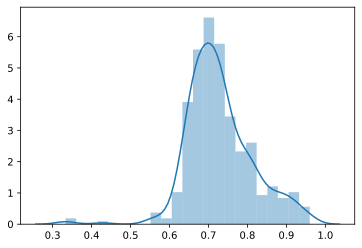

In [4]:
accuracies = dict()

for index, row in df.iterrows():
    accuracies[tuple(sorted(row['activation_functions']))] = row['MAX:accuracy.mean']

sns.distplot(list(accuracies.values()))
    
marginal_gains = list()
    
for (co1, acc1), (co2, acc2) in permutations(accuracies.items(), 2):
    if (len(co1) == len(co2) - 1) and set(co1).issubset(co2):
        element, = [e for e in co2 if e not in co1]
        marginal_gains.append({'activation function': function_names[element], 'marginal gain': acc2 - acc1})
            
marginal_gains = pd.DataFrame(marginal_gains)

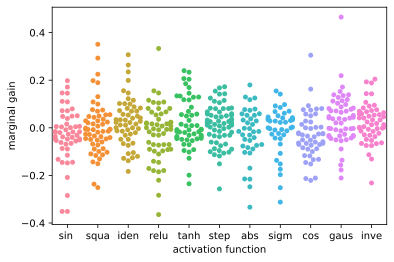

In [5]:
sns.swarmplot(x="activation function", y="marginal gain", data=marginal_gains)
plt.show()

In [6]:
for i,f in enumerate(function_names):
    df[f] = [i in row['activation_functions'] for index, row in df.iterrows()]

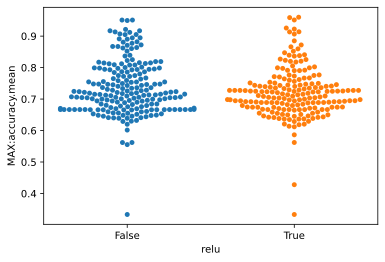

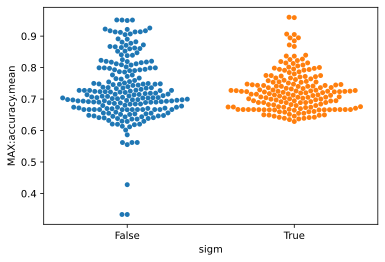

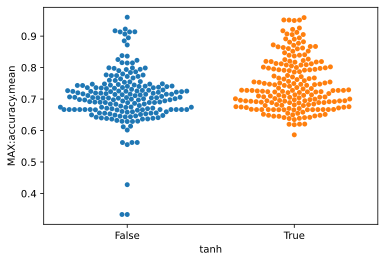

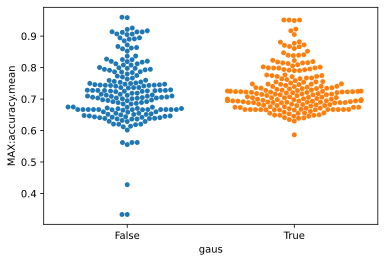

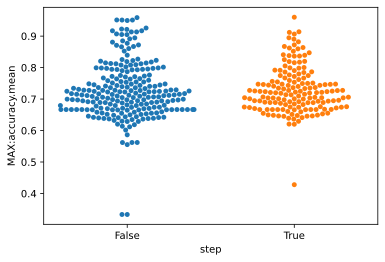

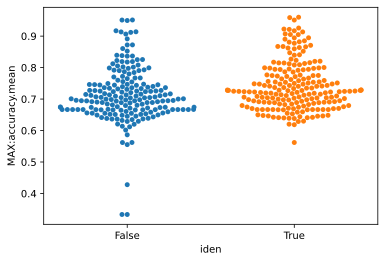

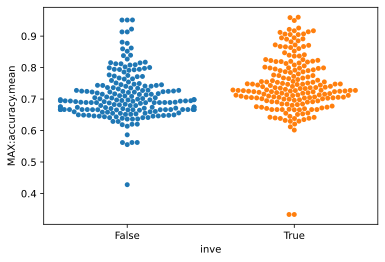

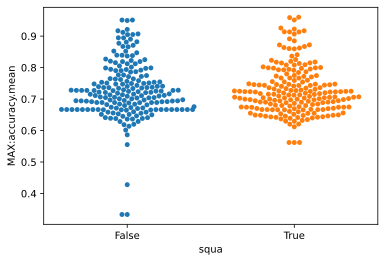

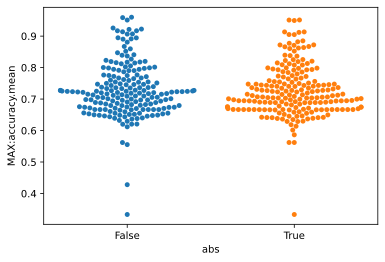

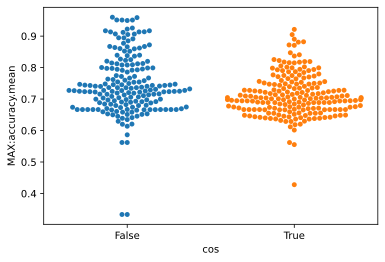

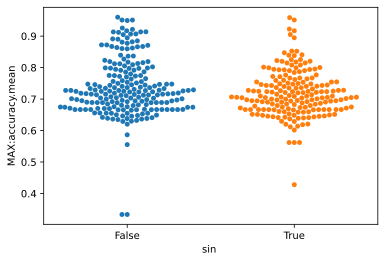

In [7]:
for f in function_names:
    sns.swarmplot(x=f, y="MAX:accuracy.mean", data=df)
    plt.show()

In [8]:
df

,MIN:log_loss.min,MAX:log_loss.min,MIN:log_loss.mean,MAX:log_loss.mean,MIN:log_loss.max,MAX:log_loss.max,MIN:accuracy.min,MAX:accuracy.min,MIN:accuracy.mean,MAX:accuracy.mean,...,sigm,tanh,gaus,step,iden,inve,squa,abs,cos,sin
0,0.337744,0.653928,2.251529,5.559931,16.535729,22.072347,0.333333,0.333333,0.599267,0.669533,...,True,False,True,False,True,False,True,True,True,False
1,0.426233,0.886586,0.822723,0.948658,1.006223,1.532379,0.233333,0.366667,0.620000,0.819067,...,True,True,True,True,False,True,False,True,True,False
2,0.592143,1.010663,0.946155,1.071138,1.676239,2.263833,0.333333,0.346667,0.559867,0.628933,...,False,False,False,False,False,False,False,True,True,False
3,0.067089,0.224443,0.465982,1.036944,0.961403,11.513049,0.333333,0.513333,0.662000,0.747600,...,False,False,True,True,True,True,False,True,True,False
4,0.582855,1.010643,0.852031,1.270133,1.210914,4.137697,0.333333,0.440000,0.590200,0.670867,...,True,False,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,0.485470,0.517661,0.622910,0.650328,1.676373,2.294860,0.333333,0.660000,0.732800,0.740133,...,True,False,True,True,False,True,False,True,False,True
390,0.443159,0.886731,0.954356,6.774389,1.532004,22.007279,0.333333,0.333333,0.609067,0.620267,...,False,True,False,False,True,False,True,False,True,False
391,0.748243,0.790214,0.857020,0.887481,2.244277,2.244458,0.333333,0.333333,0.662333,0.688933,...,True,True,True,True,True,False,False,False,True,False
392,0.436837,0.665520,0.661299,1.006987,1.107628,10.692993,0.100000,0.493333,0.626867,0.718467,...,False,False,False,True,True,True,False,False,True,False


In [10]:
accuracies = dict()

for index, row in df.iterrows():
    accuracies[tuple(sorted(row['activation_functions']))] = row['MAX:accuracy.mean']

paired_samples = list()
    
for (co1, acc1), (co2, acc2) in permutations(accuracies.items(), 2):
    if (len(co1) == len(co2) - 1) and set(co1).issubset(co2):
        element, = [e for e in co2 if e not in co1]
        paired_samples.append({'activation function': function_names[element], 'acc with': acc2, 'acc without': acc1})

paired_samples = pd.DataFrame(paired_samples)

In [11]:
rows = list()
for fn in function_names:
    data = paired_samples[paired_samples['activation function'] == fn]
    t, p = ttest_rel(data['acc with'], data['acc without'])
    cells = [fn, f"{t:.2}", f"{p:.2%}"]
    if p < 0.05:
        cells = [f"**{cell}**" for cell in cells]
    rows.append(cells)
print(tabulate(rows, tablefmt='grid', headers=('activation function', 't-value', 'p-value')))

+-----------------------+-----------+-----------+
| activation function   | t-value   | p-value   |
+=======================+===========+===========+
| relu                  | -1.4      | 17.90%    |
+-----------------------+-----------+-----------+
| sigm                  | -0.58     | 56.40%    |
+-----------------------+-----------+-----------+
| tanh                  | 1.3       | 18.48%    |
+-----------------------+-----------+-----------+
| **gaus**              | **2.4**   | **2.22%** |
+-----------------------+-----------+-----------+
| step                  | 1.2       | 24.48%    |
+-----------------------+-----------+-----------+
| iden                  | 2.0       | 5.29%     |
+-----------------------+-----------+-----------+
| inve                  | 1.8       | 7.49%     |
+-----------------------+-----------+-----------+
| squa                  | -0.028    | 97.76%    |
+-----------------------+-----------+-----------+
| abs                   | -1.3      | 19.39%    |


In [12]:
print(series.full_base_params())

{'config': {'num_workers': 1, 'debug': True, 'backend': 'numpy'}, 'postopt': {'run_postopt': True, 'compile_report': False, 'num_weights': 100, 'num_samples': -1}, 'sampling': {'seed': 0, 'post_init_seed': False, 'distribution': 'lognormal', 'lower_bound': -2, 'upper_bound': 2, 'mean': 0, 'sigma': 0.5, 'num_weights_per_iteration': 1, 'num_samples_per_iteration': -1, 'hof_evaluation_iterations': 20, 'num_weight_samples_per_iteration': 5}, 'task': {'name': 'iris', 'sample_order_seed': 0, 'test_portion': 0.2, 'sample_length': 10, 'num_categories': 8}, 'storage': {'data_base_path': 'data', 'log_filename': 'execution.log', 'commit_elite_freq': -1, 'commit_metrics_freq': 10}, 'population': {'num_generations': 200, 'size': 100, 'initial_enabled_edge_prob': 0.05, 'initial_genes': 'full', 'hof_size': 10, 'enable_edge_signs': False, 'enabled_activation_funcs': 'all'}, 'selection': {'use_tournaments': True, 'elite_ratio': 0.1, 'culling_ratio': 0.2, 'tournament_size': 5, 'objectives': ['-log_loss.